In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/vectorized_data.csv')
df.head()

,sentence,hate,category,token,vec
0,অসীম সৌন্দর্য বোঝা স্মার্ট বোঝা মান মানুষ রাসু...,0,religion,"['অসীম', 'সৌন্দর্য', 'বোঝা', 'স্মার্ট', 'বোঝা'...",[-0.01497428 0.08873386 0.02271434 0.056933...
1,মাগি মাগি মর যা,1,crime,"['মাগি', 'মাগি', 'মর', 'যা']",[-2.24201421e-02 2.10984946e-01 3.13066845e-...
2,রিফাত মারা,0,crime,"['রিফাত', 'মারা']",[-3.24658379e-02 2.21859217e-01 3.75445386e-...
3,প্রিয় ভক্ত মিজানু রহমান,0,religion,"['প্রিয়', 'ভক্ত', 'মিজানু', 'রহমান']",[-0.01089375 0.10535828 0.01994424 0.063042...
4,তাহা জন সিন্স শালা ফালতু,1,religion,"['তাহা', 'জন', 'সিন্স', 'শালা', 'ফালতু']",[-0.02635221 0.20205662 0.03821389 0.128290...


## Convert the string representations back to NumPy arrays

In [3]:
df['vec'] = df['vec'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

In [4]:
df.shape

(17300, 5)

## Seperate Labeled and Unlabeled Data in 70:30 Ratio

In [5]:
unlabeled_df, labeled_df = train_test_split(df, test_size=0.3, random_state=42)

In [6]:
labeled_df.shape

(5190, 5)

In [7]:
unlabeled_df.shape

(12110, 5)

In [8]:
unlabeled_df['hate'] = -1

In [9]:
unlabeled_df['hate'].value_counts()

-1    12110
Name: hate, dtype: int64

## Seperate 20% as Test Data from Labeled Data

In [10]:
labeled_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42)

In [11]:
test_df.shape

(1038, 5)

In [12]:
labeled_df.shape

(4152, 5)

In [13]:
labeled_df['hate'].value_counts()

1    2089
0    2063
Name: hate, dtype: int64

## Combine Labeled and Unlabeled Data

In [14]:
df = pd.concat([labeled_df, unlabeled_df], axis=0, ignore_index=True)

In [15]:
df.shape

(16262, 5)

In [16]:
df = shuffle(df, random_state=0)

In [17]:
df['hate'].value_counts()

-1    12110
 1     2089
 0     2063
Name: hate, dtype: int64

## Self Training and Featuring Engineering using word2vec

In [40]:
X = df['vec'].to_list()
y = df['hate'].to_list()

### SVM

In [19]:
import time

In [63]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = SVC(C=400, kernel='linear', probability=True),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 6785 new labels.
End of iteration 2, added 2560 new labels.
End of iteration 3, added 720 new labels.
End of iteration 4, added 205 new labels.
End of iteration 5, added 100 new labels.
End of iteration 6, added 46 new labels.
End of iteration 7, added 27 new labels.
End of iteration 8, added 14 new labels.
End of iteration 9, added 8 new labels.
End of iteration 10, added 4 new labels.
End of iteration 11, added 3 new labels.
End of iteration 12, added 2 new labels.
End of iteration 13, added 3 new labels.


In [64]:
training_time

2500.8008286952972

In [65]:
y_pred = st_clf.predict(labeled_df['vec'].to_list())
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.7996146435452793

In [66]:
y_pred = st_clf.predict(test_df['vec'].to_list())
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.8005780346820809

In [67]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       529
           1       0.84      0.73      0.78       509

    accuracy                           0.80      1038
   macro avg       0.81      0.80      0.80      1038
weighted avg       0.81      0.80      0.80      1038



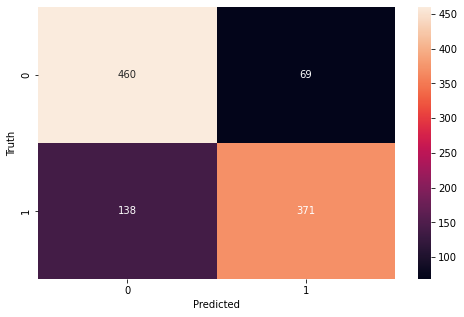

In [68]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

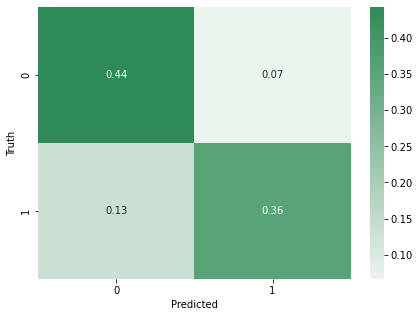

In [5]:
import numpy as np

cm = [[460, 69],
      [138, 371]]

# Calculate percentages
total = np.sum(cm)
percentages = (cm / total) 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(7, 5))
# Use a colormap that doesn't include black for low values
cmap = sn.light_palette("seagreen", as_cmap=True) 
sn.heatmap(percentages, annot=True, fmt='.2f', cmap=cmap)  # Format as percentage with two decimal places
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()


In [69]:
df_svc = df.copy()

In [70]:
len(st_clf.transduction_)

16262

In [71]:
df_svc['psudo_label'] = st_clf.transduction_

In [72]:
df_svc.to_csv('data/psudo_labeled_svc.csv', index=False)

## Random Forest

In [28]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators=200),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 5497 new labels.
End of iteration 2, added 1907 new labels.
End of iteration 3, added 881 new labels.
End of iteration 4, added 463 new labels.
End of iteration 5, added 309 new labels.
End of iteration 6, added 187 new labels.
End of iteration 7, added 151 new labels.
End of iteration 8, added 119 new labels.
End of iteration 9, added 95 new labels.
End of iteration 10, added 78 new labels.
End of iteration 11, added 63 new labels.
End of iteration 12, added 40 new labels.
End of iteration 13, added 44 new labels.
End of iteration 14, added 28 new labels.
End of iteration 15, added 44 new labels.
End of iteration 16, added 24 new labels.
End of iteration 17, added 19 new labels.
End of iteration 18, added 25 new labels.
End of iteration 19, added 17 new labels.
End of iteration 20, added 14 new labels.
End of iteration 21, added 26 new labels.
End of iteration 22, added 25 new labels.
End of iteration 23, added 14 new labels.
End of iteration 24, added 11 new

In [29]:
training_time

2406.109822511673

In [30]:
y_pred = st_clf.predict(labeled_df['vec'].to_list())
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.9927745664739884

In [31]:
y_pred = st_clf.predict(test_df['vec'].to_list())
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.7620423892100193

In [32]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       529
           1       0.79      0.70      0.74       509

    accuracy                           0.76      1038
   macro avg       0.76      0.76      0.76      1038
weighted avg       0.76      0.76      0.76      1038



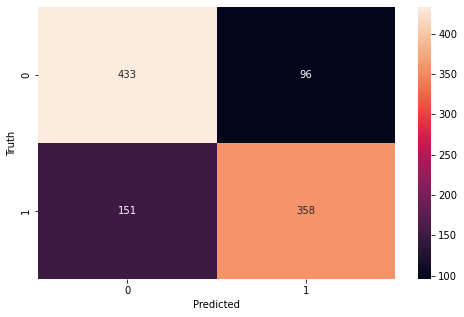

In [33]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [34]:
df_rf = df.copy()

In [35]:
st_clf.transduction_

array([ 1, -1,  0, ...,  0,  1,  1])

In [36]:
len(st_clf.transduction_)

16262

In [37]:
df_rf['psudo_label'] = st_clf.transduction_

In [38]:
df_rf.head()

,sentence,hate,category,token,vec,psudo_label
10554,দিনের বাচ্চা কই বালই হয়ই,-1,religion,"['দিনের', 'বাচ্চা', 'কই', 'বালই', 'হয়ই']","[-0.0270244231, 0.200643005, 0.0361602905, 0.1...",1
12325,এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস এককলায়মাগিরহয়না,-1,crime,"['এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস', 'এককলায়মাগির...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1
6710,মঝা দুইজনে করছো সাস্থি দুইজনে পেতে স্যারের দুশ...,-1,crime,"['মঝা', 'দুইজনে', 'করছো', 'সাস্থি', 'দুইজনে', ...","[-0.01142999, 0.07491128, 0.01610502, 0.047364...",0
2092,ভিড়িও টা ভালো লাগল,0,religion,"['ভিড়িও', 'টা', 'ভালো', 'লাগল']","[-0.03091348, 0.28345488, 0.05813488, 0.170068...",0
12102,খেলোয়াড়দের বাংলাদেশের খেলোয়াড়দের সাদিনতা নাই!এ...,-1,sports,"['খেলোয়াড়দের', 'বাংলাদেশের', 'খেলোয়াড়দের', 'সা...","[-0.02181379, 0.1577958, 0.03383988, 0.0985236...",0


In [39]:
df_rf.to_csv('data/psudo_labeled_rf.csv', index=False)

## Logistic Regression

In [40]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = LogisticRegression(solver='liblinear',multi_class='auto', C=400),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 5844 new labels.
End of iteration 2, added 2003 new labels.
End of iteration 3, added 1048 new labels.
End of iteration 4, added 641 new labels.
End of iteration 5, added 333 new labels.
End of iteration 6, added 146 new labels.
End of iteration 7, added 50 new labels.
End of iteration 8, added 13 new labels.
End of iteration 9, added 14 new labels.
End of iteration 10, added 5 new labels.
End of iteration 11, added 1 new labels.


In [41]:
training_time

21.29619812965393

In [42]:
y_pred = st_clf.predict(labeled_df['vec'].to_list())
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.7866088631984586

In [43]:
y_pred = st_clf.predict(test_df['vec'].to_list())
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.789980732177264

In [44]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       529
           1       0.84      0.70      0.77       509

    accuracy                           0.79      1038
   macro avg       0.80      0.79      0.79      1038
weighted avg       0.80      0.79      0.79      1038



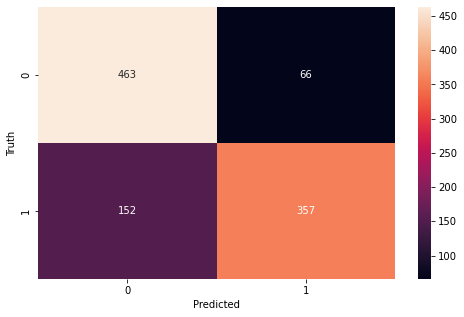

In [45]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [46]:
df_lr = df.copy()

In [47]:
len(st_clf.transduction_)

16262

In [48]:
df_lr['psudo_label'] = st_clf.transduction_

In [49]:
df_lr.head()

,sentence,hate,category,token,vec,psudo_label
10554,দিনের বাচ্চা কই বালই হয়ই,-1,religion,"['দিনের', 'বাচ্চা', 'কই', 'বালই', 'হয়ই']","[-0.0270244231, 0.200643005, 0.0361602905, 0.1...",1
12325,এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস এককলায়মাগিরহয়না,-1,crime,"['এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস', 'এককলায়মাগির...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
6710,মঝা দুইজনে করছো সাস্থি দুইজনে পেতে স্যারের দুশ...,-1,crime,"['মঝা', 'দুইজনে', 'করছো', 'সাস্থি', 'দুইজনে', ...","[-0.01142999, 0.07491128, 0.01610502, 0.047364...",-1
2092,ভিড়িও টা ভালো লাগল,0,religion,"['ভিড়িও', 'টা', 'ভালো', 'লাগল']","[-0.03091348, 0.28345488, 0.05813488, 0.170068...",0
12102,খেলোয়াড়দের বাংলাদেশের খেলোয়াড়দের সাদিনতা নাই!এ...,-1,sports,"['খেলোয়াড়দের', 'বাংলাদেশের', 'খেলোয়াড়দের', 'সা...","[-0.02181379, 0.1577958, 0.03383988, 0.0985236...",0


In [50]:
df_lr.to_csv('data/psudo_labeled_lr.csv', index=False)

## Decision Tree

In [52]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = DecisionTreeClassifier(criterion='entropy'),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 11841 new labels.
End of iteration 2, added 33 new labels.
End of iteration 3, added 5 new labels.


In [53]:
training_time

40.41966390609741

In [54]:
y_pred = st_clf.predict(labeled_df['vec'].to_list())
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.9927745664739884

In [55]:
y_pred = st_clf.predict(test_df['vec'].to_list())
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.6878612716763006

In [56]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       529
           1       0.69      0.67      0.68       509

    accuracy                           0.69      1038
   macro avg       0.69      0.69      0.69      1038
weighted avg       0.69      0.69      0.69      1038



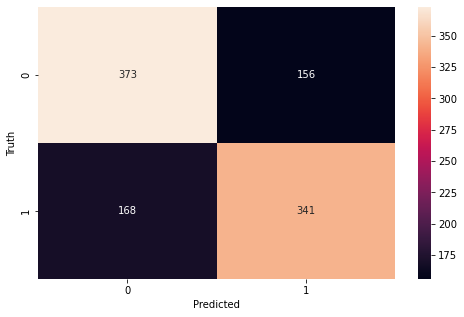

In [57]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [58]:
df_dt = df.copy()

In [59]:
len(st_clf.transduction_)

16262

In [60]:
df_dt['psudo_label'] = st_clf.transduction_

In [61]:
df_dt.head()

,sentence,hate,category,token,vec,psudo_label
10554,দিনের বাচ্চা কই বালই হয়ই,-1,religion,"['দিনের', 'বাচ্চা', 'কই', 'বালই', 'হয়ই']","[-0.0270244231, 0.200643005, 0.0361602905, 0.1...",1
12325,এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস এককলায়মাগিরহয়না,-1,crime,"['এইমাগিআগেথেকেবাইরেখাওয়ারঅববাস', 'এককলায়মাগির...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1
6710,মঝা দুইজনে করছো সাস্থি দুইজনে পেতে স্যারের দুশ...,-1,crime,"['মঝা', 'দুইজনে', 'করছো', 'সাস্থি', 'দুইজনে', ...","[-0.01142999, 0.07491128, 0.01610502, 0.047364...",1
2092,ভিড়িও টা ভালো লাগল,0,religion,"['ভিড়িও', 'টা', 'ভালো', 'লাগল']","[-0.03091348, 0.28345488, 0.05813488, 0.170068...",0
12102,খেলোয়াড়দের বাংলাদেশের খেলোয়াড়দের সাদিনতা নাই!এ...,-1,sports,"['খেলোয়াড়দের', 'বাংলাদেশের', 'খেলোয়াড়দের', 'সা...","[-0.02181379, 0.1577958, 0.03383988, 0.0985236...",1


In [62]:
df_dt.to_csv('data/psudo_labeled_dt.csv', index=False)

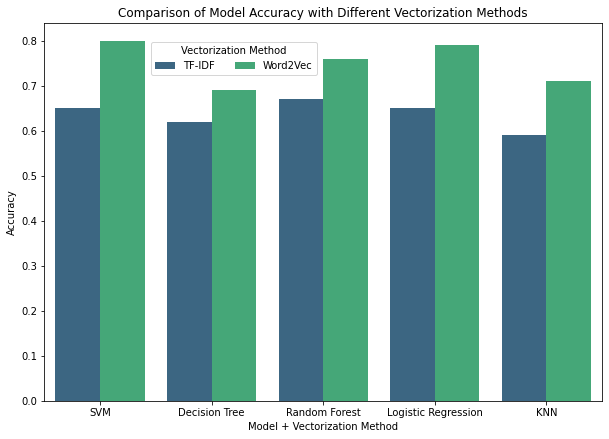

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for tf-idf vectorizer
tfidf_data = {
    'SVM': 0.65,
    'Decision Tree': 0.62,
    'Random Forest': 0.67,
    'Logistic Regression': 0.65,
    'KNN': 0.59
}

# Data for Word2Vec
word2vec_data = {
    'SVM': 0.80,
    'Decision Tree': 0.69,
    'Random Forest': 0.76,
    'Logistic Regression': 0.79,
    'KNN': 0.71
}

df_tfidf = pd.DataFrame(list(tfidf_data.items()), columns=['Model', 'Accuracy'])
df_tfidf['Vectorization'] = 'TF-IDF'

df_word2vec = pd.DataFrame(list(word2vec_data.items()), columns=['Model', 'Accuracy'])
df_word2vec['Vectorization'] = 'Word2Vec'

# Combine the DataFrames
df_combined = pd.concat([df_tfidf, df_word2vec])

# Create a barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Vectorization', data=df_combined, palette='viridis')
plt.title('Comparison of Model Accuracy with Different Vectorization Methods')
plt.xlabel('Model + Vectorization Method')
plt.ylabel('Accuracy')
plt.legend(title='Vectorization Method', bbox_to_anchor=(0.34, 0.85), loc="lower center", ncol=2)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=1)

plt.show()


In [75]:
df_combined

,Model,Accuracy,Vectorization
0,SVM,0.65,TF-IDF
1,Decision Tree,0.62,TF-IDF
2,Random Forest,0.67,TF-IDF
3,Logistic Regression,0.65,TF-IDF
0,SVM,0.80,Word2Vec
1,Decision Tree,0.69,Word2Vec
2,Random Forest,0.76,Word2Vec
3,Logistic Regression,0.79,Word2Vec


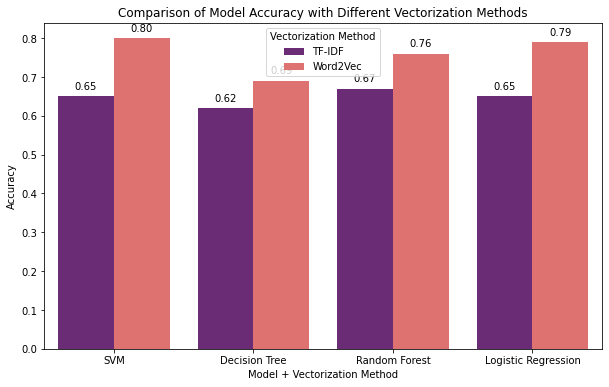

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data for tf-idf vectorizer
tfidf_data = {
    'SVM': 0.65,
    'Decision Tree': 0.62,
    'Random Forest': 0.67,
    'Logistic Regression': 0.65
}

# Data for Word2Vec
word2vec_data = {
    'SVM': 0.80,
    'Decision Tree': 0.69,
    'Random Forest': 0.76,
    'Logistic Regression': 0.79
}

# Create a DataFrame for seaborn
import pandas as pd

df_tfidf = pd.DataFrame(list(tfidf_data.items()), columns=['Model', 'Accuracy'])
df_tfidf['Vectorization'] = 'TF-IDF'

df_word2vec = pd.DataFrame(list(word2vec_data.items()), columns=['Model', 'Accuracy'])
df_word2vec['Vectorization'] = 'Word2Vec'

# Combine the DataFrames
df_combined = pd.concat([df_tfidf, df_word2vec])

# Create a barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Vectorization', data=df_combined, palette='magma')

# Add annotations
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Comparison of Model Accuracy with Different Vectorization Methods')
plt.xlabel('Model + Vectorization Method')
plt.ylabel('Accuracy')
plt.legend(title='Vectorization Method')
plt.show()


## Multinomial Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X is your input data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [55]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = MultinomialNB(),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 6533 new labels.
End of iteration 2, added 4842 new labels.


In [56]:
y_pred = st_clf.predict(scaler.fit_transform(labeled_df['vec'].to_list()))
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.5443159922928709

In [57]:
y_pred = st_clf.predict(scaler.fit_transform(test_df['vec'].to_list()))
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.5404624277456648

In [30]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.56      0.44      0.49       529
           1       0.53      0.64      0.58       509

    accuracy                           0.54      1038
   macro avg       0.54      0.54      0.54      1038
weighted avg       0.54      0.54      0.54      1038



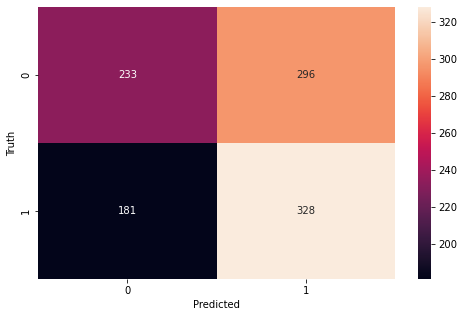

In [31]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

## KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
start_time = time.time()

st_clf = SelfTrainingClassifier(
    base_estimator = KNeighborsClassifier(n_neighbors=3),
    threshold=.75,
    max_iter=None,
    verbose = True)

st_clf.fit(X, y)

training_time = time.time() - start_time

End of iteration 1, added 5887 new labels.
End of iteration 2, added 2179 new labels.
End of iteration 3, added 725 new labels.
End of iteration 4, added 254 new labels.
End of iteration 5, added 110 new labels.
End of iteration 6, added 36 new labels.
End of iteration 7, added 13 new labels.
End of iteration 8, added 7 new labels.
End of iteration 9, added 1 new labels.


In [44]:
y_pred = st_clf.predict(labeled_df['vec'].to_list())
accuracy = accuracy_score(labeled_df['hate'], y_pred)
accuracy

0.8374277456647399

In [45]:
y_pred = st_clf.predict(test_df['vec'].to_list())
accuracy = accuracy_score(test_df['hate'], y_pred)
accuracy

0.7119460500963392

In [46]:
print(classification_report(test_df['hate'], y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       529
           1       0.73      0.66      0.69       509

    accuracy                           0.71      1038
   macro avg       0.71      0.71      0.71      1038
weighted avg       0.71      0.71      0.71      1038



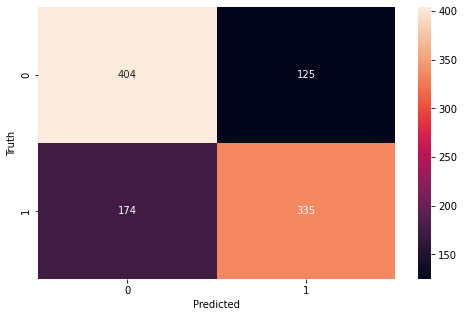

In [47]:
cm = confusion_matrix(test_df['hate'], y_pred)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(8, 5))
sn.heatmap(cm, annot=True, fmt='d')  
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()